In [5]:
import pandas as pd

csv_name = "fake_job_postings.csv"  # este es el que sale en tu captura
df = pd.read_csv(csv_name)

print(df.shape)
df.head()


(17880, 18)


,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

%matplotlib inline

print("Shape original:", df.shape)
print("Columnas:", df.columns.tolist())

# columnas de texto que vamos a usar (las que existan)
cols_text = ["title", "company_profile", "description", "requirements", "benefits"]
target_col = "fraudulent"

cols_text = [c for c in cols_text if c in df.columns]
print("Columnas de texto que usaré:", cols_text)

# Relleno NaN por cadenas vacías
for c in cols_text:
    df[c] = df[c].fillna("")

# Combino todas en una sola columna de texto
df["text"] = df[cols_text].agg(" ".join, axis=1)

# Me quedo solo con texto + etiqueta
df = df[["text", target_col]].copy()

# Quito filas sin etiqueta o sin texto (por si acaso)
df = df[(df[target_col].notna()) & (df["text"].str.strip() != "")]
df[target_col] = df[target_col].astype(int)

print("\nDespués de limpiar:")
print("Shape:", df.shape)
print("Distribución de clases:\n", df[target_col].value_counts())
df.head(3)


Shape original: (17880, 18)
Columnas: ['job_id', 'title', 'location', 'department', 'salary_range', 'company_profile', 'description', 'requirements', 'benefits', 'telecommuting', 'has_company_logo', 'has_questions', 'employment_type', 'required_experience', 'required_education', 'industry', 'function', 'fraudulent']
Columnas de texto que usaré: ['title', 'company_profile', 'description', 'requirements', 'benefits']

Después de limpiar:
Shape: (17880, 2)
Distribución de clases:
 fraudulent
0    17014
1      866
Name: count, dtype: int64


,text,fraudulent
0,"Marketing Intern We're Food52, and we've creat...",0
1,Customer Service - Cloud Video Production 90 S...,0
2,Commissioning Machinery Assistant (CMA) Valor ...,0


In [9]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

X = df["text"].values
y = df["fraudulent"].values

X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=RANDOM_SEED,
    stratify=y
)

print("Tamaño train:", len(X_train))
print("Tamaño val  :", len(X_val))

# Vectorizador TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=5000,     # aqui ponemos un límite para que no se dispare la dimensión
    stop_words="english"   
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf   = tfidf.transform(X_val)

print("Shape TF-IDF train:", X_train_tfidf.shape)
print("Shape TF-IDF val  :", X_val_tfidf.shape)

# A numpy float32 para PyTorch
X_train_np = X_train_tfidf.toarray().astype(np.float32)
X_val_np   = X_val_tfidf.toarray().astype(np.float32)

y_train_np = y_train.astype(np.int64)
y_val_np   = y_val.astype(np.int64)

class NumpyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = NumpyDataset(X_train_np, y_train_np)
val_ds   = NumpyDataset(X_val_np, y_val_np)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=64, shuffle=False)

# Comprobación rápida de un batch
xb, yb = next(iter(train_loader))
print("Batch X:", xb.shape)
print("Batch y:", yb.shape, "Valores únicos:", yb.unique())


Tamaño train: 14304
Tamaño val  : 3576
Shape TF-IDF train: (14304, 5000)
Shape TF-IDF val  : (3576, 5000)
Batch X: torch.Size([64, 5000])
Batch y: torch.Size([64]) Valores únicos: tensor([0, 1])


Usando dispositivo: cpu
FakeJobNet(
  (net): Sequential(
    (0): Linear(in_features=5000, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=2, bias=True)
  )
)

Época 1/6
  train -> Loss: 0.1629 | Acc: 0.9557
  val   -> Loss: 0.0801 | Acc: 0.9718

Época 2/6
  train -> Loss: 0.0570 | Acc: 0.9804
  val   -> Loss: 0.0500 | Acc: 0.9821

Época 3/6
  train -> Loss: 0.0318 | Acc: 0.9899
  val   -> Loss: 0.0444 | Acc: 0.9838

Época 4/6
  train -> Loss: 0.0175 | Acc: 0.9951
  val   -> Loss: 0.0447 | Acc: 0.9849

Época 5/6
  train -> Loss: 0.0101 | Acc: 0.9975
  val   -> Loss: 0.0450 | Acc: 0.9849

Época 6/6
  train -> Loss: 0.0059 | Acc: 0.9988
  val   -> Loss: 0.0493 | Acc: 0.9838


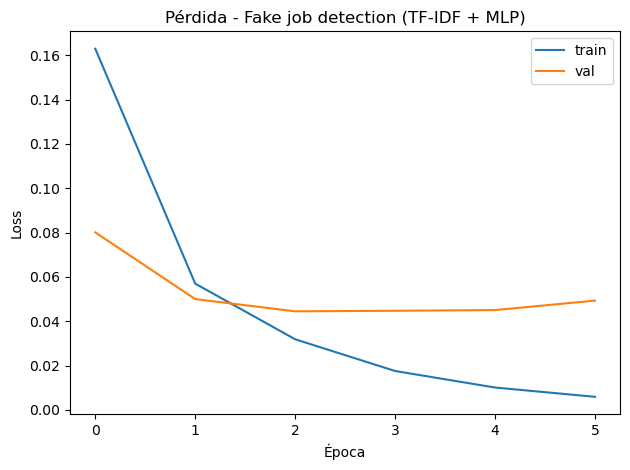

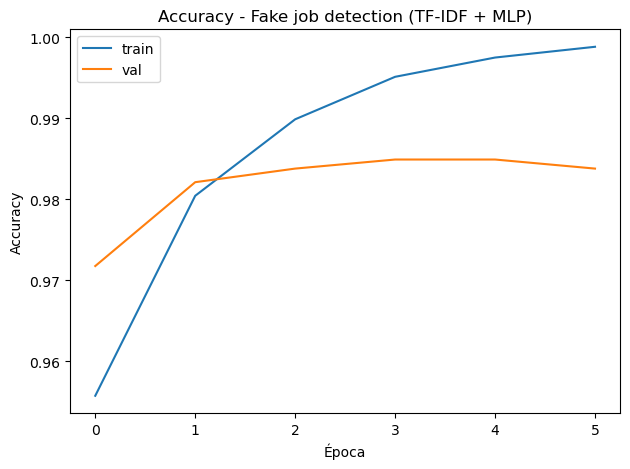


== Classification report (validación) ==
              precision    recall  f1-score   support

        real       0.99      1.00      0.99      3403
        fake       0.89      0.76      0.82       173

    accuracy                           0.98      3576
   macro avg       0.94      0.88      0.91      3576
weighted avg       0.98      0.98      0.98      3576

Matriz de confusión:
 [[3386   17]
 [  41  132]]


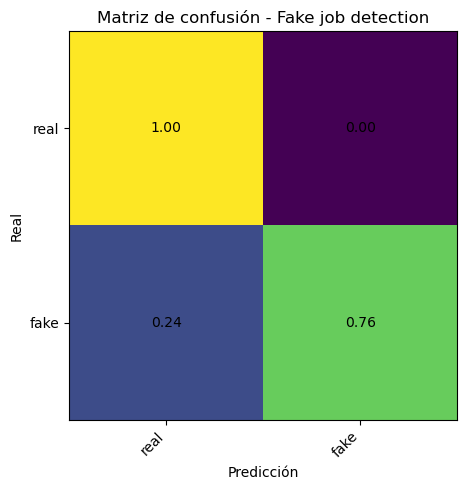

Guardada matriz de confusión en: fake_jobs_confusion_matrix.png


In [11]:
# Usamos nuestra CPU 
device = torch.device("cpu")
print("Usando dispositivo:", device)

input_dim = X_train_np.shape[1]
num_classes = 2

class FakeJobNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=256):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x):
        return self.net(x)

model = FakeJobNet(input_dim=input_dim, hidden_dim=256).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

print(model)

def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total = 0

    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)

        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * xb.size(0)
        running_corrects += (preds == yb).sum().item()
        total += xb.size(0)

    epoch_loss = running_loss / total
    epoch_acc = running_corrects / total
    return epoch_loss, epoch_acc

def eval_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total = 0

    all_preds = []
    all_targets = []

    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)

            outputs = model(xb)
            loss = criterion(outputs, yb)
            _, preds = torch.max(outputs, 1)

            running_loss += loss.item() * xb.size(0)
            running_corrects += (preds == yb).sum().item()
            total += xb.size(0)

            all_preds.append(preds.cpu().numpy())
            all_targets.append(yb.cpu().numpy())

    epoch_loss = running_loss / total
    epoch_acc = running_corrects / total

    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)

    return epoch_loss, epoch_acc, all_targets, all_preds

NUM_EPOCHS = 6  

history = {
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": []
}

for epoch in range(1, NUM_EPOCHS + 1):
    print(f"\nÉpoca {epoch}/{NUM_EPOCHS}")
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc, y_true, y_pred = eval_epoch(model, val_loader, criterion, device)

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    print(f"  train -> Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
    print(f"  val   -> Loss: {val_loss:.4f} | Acc: {val_acc:.4f}")

# === Gráficas ===
plt.figure()
plt.plot(history["train_loss"], label="train")
plt.plot(history["val_loss"], label="val")
plt.xlabel("Época"); plt.ylabel("Loss"); plt.legend()
plt.title("Pérdida - Fake job detection (TF-IDF + MLP)")
plt.tight_layout()
plt.savefig("fake_jobs_loss_curve.png", dpi=150)
plt.show()

plt.figure()
plt.plot(history["train_acc"], label="train")
plt.plot(history["val_acc"], label="val")
plt.xlabel("Época"); plt.ylabel("Accuracy"); plt.legend()
plt.title("Accuracy - Fake job detection (TF-IDF + MLP)")
plt.tight_layout()
plt.savefig("fake_jobs_acc_curve.png", dpi=150)
plt.show()

print("\n== Classification report (validación) ==")
print(classification_report(y_true, y_pred, target_names=["real", "fake"]))

cm = confusion_matrix(y_true, y_pred)
print("Matriz de confusión:\n", cm)

def plot_confusion_matrix(cm, class_names, normalize=True, save_path="fake_jobs_confusion_matrix.png"):
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

    fig, ax = plt.subplots(figsize=(5, 5))
    im = ax.imshow(cm, interpolation="nearest")
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    ax.set_xticklabels(class_names, rotation=45, ha="right")
    ax.set_yticklabels(class_names)

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, f"{cm[i, j]:.2f}", ha="center", va="center")

    ax.set_xlabel("Predicción")
    ax.set_ylabel("Real")
    ax.set_title("Matriz de confusión - Fake job detection")
    plt.tight_layout()
    plt.savefig(save_path, dpi=150)
    plt.show()
    print("Guardada matriz de confusión en:", save_path)

plot_confusion_matrix(cm, ["real", "fake"])
